In [1]:
import base64
import csv
import os
from itertools import combinations

import openai
import pandas as pd
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)
from pydantic import BaseModel, confloat

In [2]:
with open("sahaj_key.txt", "r", encoding="utf-8") as keyfile:
    API_KEY = keyfile.read().strip()

BASE_PROMPT = (
    "You are assisting in a study in which you are shown pairs of rocks and "
    "rate how similar they are along various visual dimensions on a scale from 1.00 to 9.00, with 1.00 being most dissimilar, "
    "5.00 being moderately similar, and 9.00 being most similar. "
    "You only consider the visual appearance of the rocks, not their geological properties or origins. "
    "You use the full range of the 1.00-9.00 scale and err on the side of using the middle of the scale (4.50) when you are unsure. "
    "Your response includes any decimal point to the hundredths place within the specified range. "
    "You rate the similarity of the rocks on the following dimensions: "
    "Lightness: how light or dark the rocks appear overall, "
    "Grain size: how coarse or fine the textures of the rocks appear on average, "
    "Roughness: how smooth or rough the surfaces of the rocks appear, "
    "Shininess: how shiny or dull the surfaces of the rocks appear, "
    "Organization: whether the rocks are organized into systematic layers, bands, or grains, or are made up of fragments glued haphazardly together. "
    "Chromaticity: whether the rocks have warm colors (reds, yellows, oranges) or cool colors (blues, greens, purples), or are achromatic (grays, whites, and blacks). "
    "You also provide an overall similarity rating. This rating takes into account all the similarity ratings you provide for individual dimensions, but it is not limited to these dimensions and may also include other dimensions such as shape. "
    "You explain your reasoning for each rating and respond in the following format: "
    "{"
    '"lightness_explanation": <explanation of the lightness rating>,'
    '"lightness_rating": <rating>,'
    '"grain_size_explanation": <explanation of the grain size rating>,'
    '"grain_size_rating": <rating>,'
    '"roughness_explanation": <explanation of the roughness rating>,'
    '"roughness_rating": <rating>,'
    '"shininess_explanation": <explanation of the shininess rating>,'
    '"shininess_rating": <rating>,'
    '"organization_explanation": <explanation of the organization rating>,'
    '"organization_rating": <rating>,'
    '"chromaticity_explanation": <explanation of the chromaticity rating>,'
    '"chromaticity_rating": <rating>,'
    '"overall_explanation": <explanation of the overall similarity>,'
    '"overall_rating": <rating>'
    "}"
)
IMAGE_FOLDER = "data/360 Rocks"
QUESTION_PROMPT = "From 1.00-9.00, how visually similar are these two rocks?"


In [3]:
client = openai.OpenAI(
    api_key=API_KEY,
)

In [4]:
class Rating(BaseModel):
    lightness_explanation: str
    lightness_rating: confloat(ge=1.0, le=9.0)  # type: ignore
    grain_size_explanation: str
    grain_size_rating: confloat(ge=1.0, le=9.0)  # type: ignore
    roughness_explanation: str
    roughness_rating: confloat(ge=1.0, le=9.0)  # type: ignore
    shininess_explanation: str
    shininess_rating: confloat(ge=1.0, le=9.0)  # type: ignore
    organization_explanation: str
    organization_rating: confloat(ge=1.0, le=9.0)  # type: ignore
    chromaticity_explanation: str
    chromaticity_rating: confloat(ge=1.0, le=9.0)  # type: ignore
    overall_explanation: str
    overall_rating: confloat(ge=1.0, le=9.0)  # type: ignore


In [5]:
def encode_image(image, folder=IMAGE_FOLDER):
    image_path = os.path.join(folder, f"{image}.jpg")
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def create_messages(rocks, folder=IMAGE_FOLDER):
    messages = {
        "role": "user",
        "content": [{"type": "input_text", "text": QUESTION_PROMPT}]
        + [
            {
                "type": "input_image",
                "image_url": f"data:image/jpeg;base64,{encode_image(rock, folder)}",
            }
            for rock in rocks
        ],
    }
    return messages


@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(10))
def completion_with_backoff(client, **kwargs):
    return client.responses.parse(**kwargs)


def get_responses(client, rock1, rock2):
    prompt = BASE_PROMPT
    messages = [
        {"role": "system", "content": prompt},
    ]
    messages.append(create_messages((rock1, rock2)))
    response = client.responses.parse(
        model="gpt-4o",
        input=messages,
        text_format=Rating,
    )
    return response

In [6]:
rock_filenames = sorted(
    [os.path.splitext(f)[0] for f in os.listdir(IMAGE_FOLDER) if f.endswith(".jpg")]
)
ROCKS_30_DATA = "data/30_rocks_similarities.csv"
human_data = pd.read_csv(ROCKS_30_DATA, index_col=0)
pairs = [comb for comb in combinations(human_data.columns, 2)]

for i, pair in enumerate(pairs):
    rock1, rock2 = pair
    print(
        f"\033[KProcessing pair {i + 1}/{len(pairs)}: {rock1} and {rock2}",
        end="\r",
        flush=True,
    )
    human = human_data[rock1][rock2]
    response = get_responses(client, rock1, rock2)

    with open(
        "explained_multiple_similarity_responses.csv",
        mode="a",
        newline="",
        encoding="utf-8",
    ) as csvfile:
        fieldnames = [
            "index",
            "Rock1",
            "Rock2",
            "Rock1 Index",
            "Rock2 Index",
            "Human Rating",
            "ChatGPT Lightness Rating",
            "ChatGPT Lightness Explanation",
            "ChatGPT Grain Size Rating",
            "ChatGPT Grain Size Explanation",
            "ChatGPT Roughness Rating",
            "ChatGPT Roughness Explanation",
            "ChatGPT Shininess Rating",
            "ChatGPT Shininess Explanation",
            "ChatGPT Organization Rating",
            "ChatGPT Organization Explanation",
            "ChatGPT Chromaticity Rating",
            "ChatGPT Chromaticity Explanation",
            "ChatGPT Overall Rating",
            "ChatGPT Overall Explanation",
        ]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        if csvfile.tell() == 0:
            writer.writeheader()
        writer.writerow(
            {
                "index": i,
                "Rock1": rock1,
                "Rock2": rock2,
                "Rock1 Index": rock_filenames.index(rock1),
                "Rock2 Index": rock_filenames.index(rock2),
                "ChatGPT Lightness Rating": response.output_parsed.lightness_rating,
                "ChatGPT Lightness Explanation": response.output_parsed.lightness_explanation,
                "ChatGPT Grain Size Rating": response.output_parsed.grain_size_rating,
                "ChatGPT Grain Size Explanation": response.output_parsed.grain_size_explanation,
                "ChatGPT Roughness Rating": response.output_parsed.roughness_rating,
                "ChatGPT Roughness Explanation": response.output_parsed.roughness_explanation,
                "ChatGPT Shininess Rating": response.output_parsed.shininess_rating,
                "ChatGPT Shininess Explanation": response.output_parsed.shininess_explanation,
                "ChatGPT Organization Rating": response.output_parsed.organization_rating,
                "ChatGPT Organization Explanation": response.output_parsed.organization_explanation,
                "ChatGPT Chromaticity Rating": response.output_parsed.chromaticity_rating,
                "ChatGPT Chromaticity Explanation": response.output_parsed.chromaticity_explanation,
                "ChatGPT Overall Rating": response.output_parsed.overall_rating,
                "ChatGPT Overall Explanation": response.output_parsed.overall_explanation,
            }
        )

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
baseline = pd.read_csv("output/baseline/similarities.csv", index_col=0)
baseline.rename(
    columns={
        "Human Rating": "Human",
        "ChatGPT Rating": "Baseline Prompt",
    },
    inplace=True,
)

long = pd.read_csv("explained_multiple_similarity_responses.csv", index_col=0)
long.rename(
    columns={
        "Human Rating": "Human",
        "ChatGPT Overall Rating": "Long Prompt",
    },
    inplace=True,
)

In [13]:
baseline = baseline.merge(
    long,
    left_index=True,
    right_index=True,
    suffixes=("_baseline", "_long"),
)

In [14]:
baseline

,Rock1_baseline,Rock2_baseline,Rock1 Index_baseline,Rock2 Index_baseline,Human_baseline,Baseline Prompt,Rock1_long,Rock2_long,Rock1 Index_long,Rock2 Index_long,...,ChatGPT Roughness Rating,ChatGPT Roughness Explanation,ChatGPT Shininess Rating,ChatGPT Shininess Explanation,ChatGPT Organization Rating,ChatGPT Organization Explanation,ChatGPT Chromaticity Rating,ChatGPT Chromaticity Explanation,Long Prompt,ChatGPT Overall Explanation
index,,,,,,,,,,,,,,,,,,,,,
0,I_Andesite_06,I_Basalt_02,5,13,5.5294,2.814988,I_Andesite_06,I_Basalt_02,5,13,...,4.0,"Both rocks seem to have a rough texture, but t...",5.5,Both rocks appear to have a dull surface with ...,3.0,The first rock exhibits some pattern or speckl...,7.0,"Both rocks are achromatic, consisting of mostl...",4.0,"Overall, the rocks differ mainly in lightness,..."
1,I_Andesite_06,I_Diorite_10,5,33,6.7059,5.026974,I_Andesite_06,I_Diorite_10,5,33,...,8.5,"Both rocks exhibit similarly rough, uneven tex...",8.5,Neither rock appears particularly shiny; both ...,8.0,Both rocks display a similar random arrangemen...,8.5,Both rocks consist of similar achromatic color...,8.0,The rocks are quite similar in overall appeara...
2,I_Andesite_06,I_Gabbro_03,5,38,6.8824,5.343327,I_Andesite_06,I_Gabbro_03,5,38,...,7.5,The surfaces of both rocks appear to be somewh...,8.0,Neither rock is very shiny; both have a matte ...,7.5,Both rocks have a somewhat consistent granular...,9.0,"Both rocks are mainly grayscale, lacking signi...",8.0,"Overall, these rocks are highly similar in ter..."
3,I_Andesite_06,I_Granite_11,5,58,5.6324,3.106423,I_Andesite_06,I_Granite_11,5,58,...,6.0,The surfaces of both rocks appear similarly un...,4.0,The second rock seems slightly shinier due to ...,6.0,Neither rock has a clear layered or organized ...,4.0,"The first rock leans more toward grayscale, wh...",5.0,"Despite differences in color and shininess, th..."
4,I_Andesite_06,I_Obsidian_09,5,68,3.7206,1.098683,I_Andesite_06,I_Obsidian_09,5,68,...,1.5,"The first rock's surface is rough and uneven, ...",1.0,"The first rock has a dull appearance, whereas ...",2.0,"The first rock seems to have a random, haphaza...",2.0,"Both rocks are largely achromatic, but the fir...",1.5,"Overall, the rocks look quite different in mos..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,S_Rock Gypsum_02,S_Sandstone_12,313,347,2.5294,1.292228,S_Rock Gypsum_02,S_Sandstone_12,313,347,...,2.5,"The first rock looks relatively smooth, while ...",2.0,"The first rock has a slight sheen, suggesting ...",3.0,The first rock has a more structured appearanc...,2.0,"The first rock is achromatic (white/greys), wh...",2.5,"Considering the differences in color, texture,..."
431,S_Rock Gypsum_02,S_Shale_04,313,351,3.1029,1.065952,S_Rock Gypsum_02,S_Shale_04,313,351,...,3.0,The first rock seems to have a smoother surfac...,2.0,"The first rock has a shiny surface, whereas th...",3.5,The first rock seems to have some layering or ...,6.0,"The first rock is achromatic, with whites and ...",3.0,"Overall, the rocks differ significantly in lig..."
432,S_Rock Salt_12,S_Sandstone_12,335,347,1.8676,1.229949,S_Rock Salt_12,S_Sandstone_12,335,347,...,2.0,"The first rock appears smoother, possibly due ...",1.5,"The first rock is quite shiny and reflective, ...",3.0,The first rock does not show any distinctive l...,1.5,"The first rock is mostly achromatic, with clea...",2.0,"Overall, the rocks differ significantly in col..."


Text(0.5, 0, 'Human Rating')

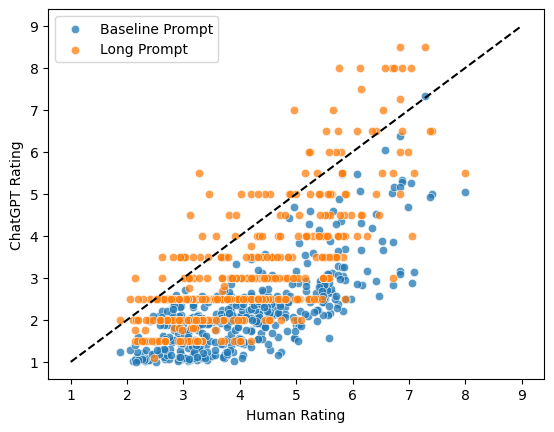

In [ ]:
sns.scatterplot(
    data=baseline,
    x="Human_baseline",
    y="Baseline Prompt",
    alpha=0.75,
    label="Baseline Prompt",
)
plt.plot([1, 9], [1, 9], "k--")
sns.scatterplot(
    data=baseline, x="Human_baseline", y="Long Prompt", alpha=0.75, label="Long Prompt"
)
plt.ylabel("ChatGPT Rating")
plt.xlabel("Human Rating")

<Axes: >

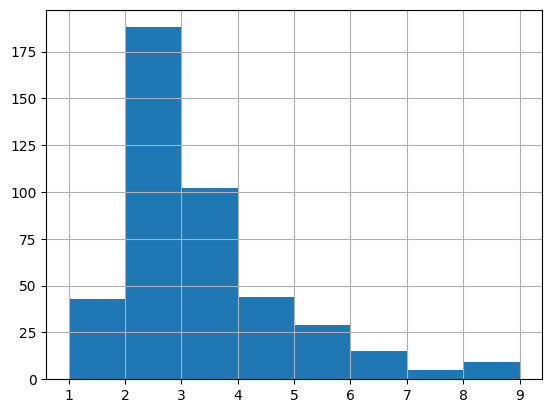

In [16]:
long["Long Prompt"].hist(bins=[1, 2, 3, 4, 5, 6, 7, 8, 9])